In [ ]:
import os
import numpy as np
import pandas as pd
import random
import glob
import gc
import time
from tqdm import tqdm
#from sklearn.model_selection import train_test_split
import cv2
#from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt
#import torchmetrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/NMA/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
# img_data = pd.read_csv('lgg-mri-segmentation/kaggle_3m/data.csv')
# img_data.head()

NameError: ignored

In [ ]:
# img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
# img_data.isnull().sum()

NameError: ignored

In [ ]:
# KNN_Imputing needed

# Starting Point!!!!!!!!!!!!!!!!!!!!!!!!

## Loading paths

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import re
pattern = r'(\d+).tif'
def extract_numbers(s):
    string = str(s)
    match = re.search(pattern,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [ ]:
import re
pattern_mask = r'(\d+)_mask.tif'
def extract_numbers_mask(s):
    string = str(s)
    match = re.search(pattern_mask,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [ ]:
# def sorting_func(my_list,sorted_list):
#     i = 0
#     while i<len(my_list):
#         sorted_list.extend(sorted(my_list[i:i+20],key = extract_numbers))
#         i+=1
# #    for i in range(0,len(my_list),20):
# #        sorted_list.extend(sorted(my_list[i:i+20],key = extract_numbers(my_list[])))
#     return sorted_list

In [ ]:
import pathlib

In [ ]:
folder_path = '/content/lgg-mri-segmentation/kaggle_3m'

# Create a Path object for the folder
#folder = pathlib.Path(folder_path)

# Get a list of all the file paths in the folder and its subdirectories
sub_folders = [f for f in pathlib.Path(folder_path).iterdir() if f.is_dir()]
original_image_lists = []
mask_image_lists = []
for sub_folder in sub_folders:
    image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and ("mask" not in str(pathlib.Path(f)))]
    mask_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and ("mask" in str(pathlib.Path(f)))]
    original_image_lists.extend(sorted(image_files,key=extract_numbers))
    mask_image_lists.extend(sorted(mask_image_files,key=extract_numbers_mask))
#     original_image_lists.extend(image_files)
#     mask_image_lists.extend(mask_image_files)

# Print out all the file paths in alphabetical order
#for file_path in sorted_file_paths:
#    print(file_path)

In [ ]:
original_image_lists

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_1.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_2.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_3.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_4.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_5.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_6.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_7.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_8.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_9.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_10.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_1997

In [ ]:
# Sort the list of file paths in alphabetical order
#sorted_original_image_lists = list()
#sorted_mask_image_lists = list()
# sorted_original_image_lists = [sorted(listy,key=extract_numbers) for listy in original_image_lists]
# sorted_mask_image_lists = [sorted(listy,key=extract_numbers_mask) for listy in mask_image_lists]

In [ ]:
df = pd.DataFrame([original_image_lists,mask_image_lists]) #Each list would be added as a row
df = df.transpose() #To Transpose and make each rows as columns
df.columns=['original_image','mask_image'] #Rename the columns
#df.to_csv("D:/Misaj/S3 S4 MTech/Project/Datasets/ISIC2019_label.csv", index = False)

In [ ]:
df.head()

,original_image,mask_image
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...


In [ ]:
df.to_csv("image_path.csv", index = False)

## defining the Unet :)

### In a U-Net architecture, the nn.Upsample module with bilinear=True is commonly used in the Up class to perform upsampling of the feature maps in the decoder part of the network.
### The Up class in a U-Net typically consists of an upsampling layer followed by a double convolution block. The upsampling layer increases the spatial resolution of the feature maps by a factor of 2 in each dimension

* what is the difference between nn.ConvTranspose2d and nn.Upsample
* Don't know if we should include biase term

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1,padding_mode='replicate', bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1,padding_mode='replicate', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)# not trainable
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)# trainable
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        #https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2),'replicate')
        x = torch.cat([x2, x1], dim=1)# concate on an axis
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)# point-wise conv

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        #self.down4 = (Down(512, 1024))#Question: why //factor fo decoding
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x = self.inc(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.up1(x4, x3)
        x6 = self.up2(x5, x2)
        x7 = self.up3(x6, x1)
        x8 = self.up4(x7, x)
        logits = self.outc(x8)
        return logits

#     def use_checkpointing(self):
#         self.inc = torch.utils.checkpoint(self.inc)
#         self.down1 = torch.utils.checkpoint(self.down1)
#         self.down2 = torch.utils.checkpoint(self.down2)
#         self.down3 = torch.utils.checkpoint(self.down3)
#         self.down4 = torch.utils.checkpoint(self.down4)
#         self.up1 = torch.utils.checkpoint(self.up1)
#         self.up2 = torch.utils.checkpoint(self.up2)
#         self.up3 = torch.utils.checkpoint(self.up3)
#         self.up4 = torch.utils.checkpoint(self.up4)
#         self.outc = torch.utils.checkpoint(self.outc)

In [ ]:
def mapping_fn(val):
    if val == 0:
      return 0
    else:
      return 1

In [ ]:
# Create a custom dataset from the image paths
class CustomDataset(data.Dataset):
    def __init__(self, image_paths,mask_paths, transform1=None,transform2=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, index):
        # Load the image and apply transforms
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('L')
        mask_path = self.mask_paths[index]
        mask = Image.open(mask_path).convert('L')
        if self.transform1 is not None:
          image = self.transform1(image).cuda()
          mask = self.transform2(mask).cuda()
        for j in range(len(mask)):
          for i in range(len(mask[j])):
            for z in range(len(mask[j][i])):
              mask[j][i][z] = mapping_fn(mask[j][i][z])

        # Return the image and its corresponding index
        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# Define the transforms to be applied to the images
transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    transforms.Normalize((0,), (1/255,))
])

In [ ]:
# Define the transforms to be applied to the images
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize((0,), (1/255,))
])

In [ ]:
df_paths = pd.read_csv("/content/image_path.csv")

In [ ]:
df_paths.columns

Index(['original_image', 'mask_image'], dtype='object')

In [ ]:
original_images = list(df_paths['original_image'])

In [ ]:
len(original_images)

3929

In [ ]:
mask_images = list(df_paths['mask_image'])

In [ ]:
type(mask_images[0])

str

In [ ]:
# Create a custom dataset from the image paths
dataset = CustomDataset(original_images[:500],mask_images[:500], transform1,transform2)

In [ ]:
dataset[1][1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [ ]:
# Define the dataloader to load the images in batches
batch_size = 4
#loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
  # Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = data.random_split(dataset, [train_size, val_size, test_size])
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Check the number of available GPUs
# num_gpus = torch.cuda.device_count()
# print(num_gpus)

In [ ]:
# Set max_split_size_mb to 100
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=100'

In [ ]:
#gc.collect()

In [ ]:
# define your UNet model
model = UNet(1,1,True).to(device)
# define your loss function
criterion = nn.BCEWithLogitsLoss()
# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
summary(model,(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             576
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,864
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
        DoubleConv-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,728
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,456
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
       DoubleConv-13        [-1, 128, 128, 128]               0
             Down-14        [-1, 128, 1

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
# train your model
for epoch in range(2):
    for images, masks in train_loader:
        #torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()
        outputs = model(images).detach()
        for i in range(len(outputs)):
          outputs[i] =F.threshold(outputs[i],0.5, 0)
        loss = criterion(outputs, masks)
        print(loss)
        loss.backward()
        optimizer.step()

tensor(0.8136, device='cuda:0')


RuntimeError: ignored

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a line
ax.plot(train_loss)

# Set the plot title and axis labels
ax.set_title('Training Loss Over Time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [ ]:
# validate your model
with torch.no_grad():
    for images, masks in val_loader:
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("validation:",loss)

# test your model
# with torch.no_grad():
#     for images, masks in test_loader:
#         outputs = model(images)
#         # evaluate performance on test set

validation: tensor(0.0422, device='cuda:0')
validation: tensor(0.0906, device='cuda:0')
validation: tensor(0.0418, device='cuda:0')
validation: tensor(0.0886, device='cuda:0')
validation: tensor(0.1291, device='cuda:0')
validation: tensor(0.0859, device='cuda:0')
validation: tensor(0.0707, device='cuda:0')
validation: tensor(0.0483, device='cuda:0')
validation: tensor(0.0851, device='cuda:0')
validation: tensor(0.0519, device='cuda:0')
validation: tensor(0.0949, device='cuda:0')
validation: tensor(0.1290, device='cuda:0')
validation: tensor(0.0377, device='cuda:0')


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NMA/final_NMA_model.pth')

In [ ]:
def calculate_iou(pred_mask, gt_mask):
    intersection = torch.logical_and(pred_mask, gt_mask)
    union = torch.logical_or(pred_mask, gt_mask)
    iou = torch.sum(intersection).item() / torch.sum(union).item()
    return iou

In [ ]:
df_paths.iloc[1010]["mask_image"]

'/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_19_mask.tif'

In [ ]:
df_paths.iloc[1017]["original_image"]

'/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_26.tif'

In [ ]:
test_dataset = CustomDataset(original_images[1010:1017],mask_images[1010:1017], transform1,transform2)

In [ ]:
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

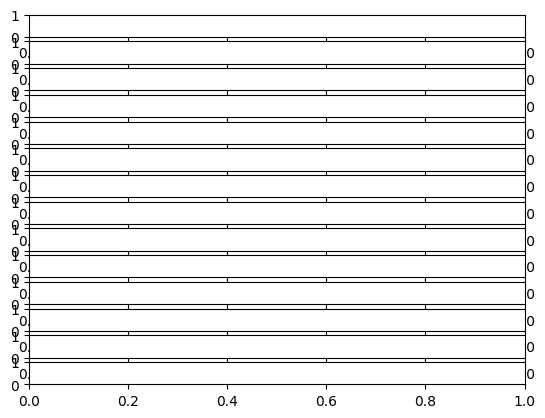

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=(len(original_images[1010:1017])*2))

In [ ]:
ev = []
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        # evaluate performance on test set
        iou_scores = []
        for i in range(outputs.shape[0]):
            plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
            plt.show()
            plt.imshow(np.squeeze(outputs[i].cpu().numpy()), cmap='gray')
            plt.show()
            plt.imshow(np.squeeze(masks[i].cpu().numpy()), cmap='gray')
            plt.show()
            iou = calculate_iou(outputs[i], masks[i])
            iou_scores.append(iou)
        ev.extend(iou_scores)

In [ ]:
model = torch.load('/content/drive/MyDrive/NMA/final_NMA_model.pth')

In [ ]:
# define your UNet model
model = UNet(1,1,True).to(device)
# define your loss function
criterion = nn.BCEWithLogitsLoss()
# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NMA/final_NMA_model.pth'))

<All keys matched successfully>

In [ ]:
# Apply a threshold to obtain the binary segmentation mask
threshold = 0.01
#binary_mask = (output > threshold).float()

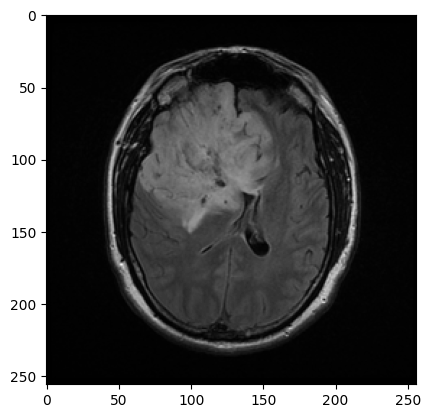

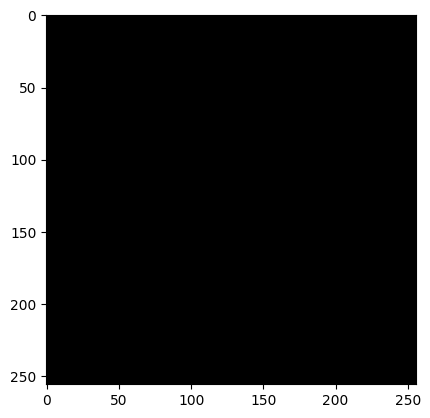

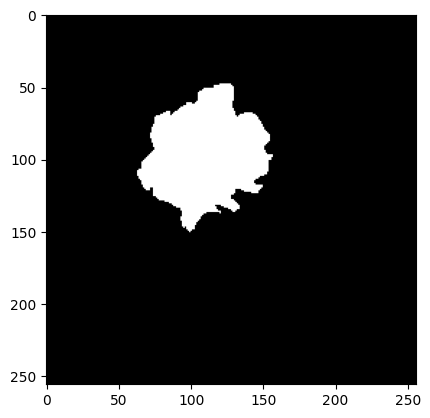

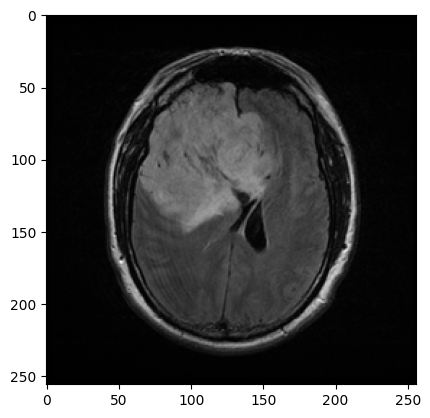

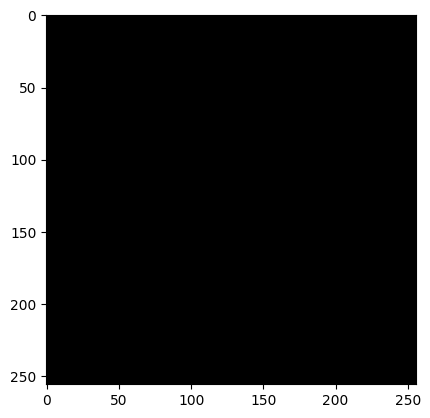

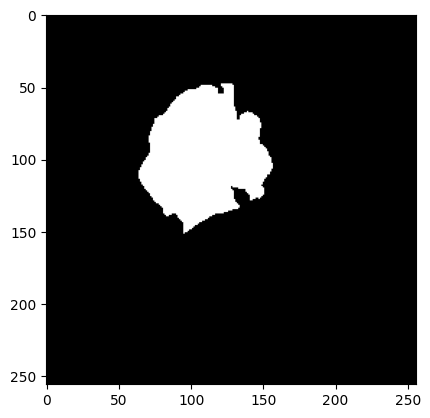

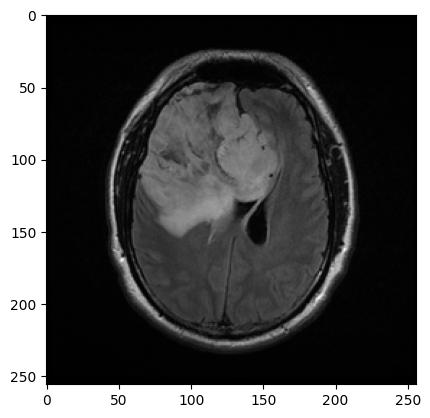

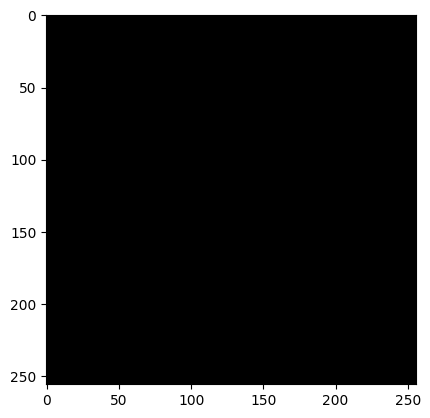

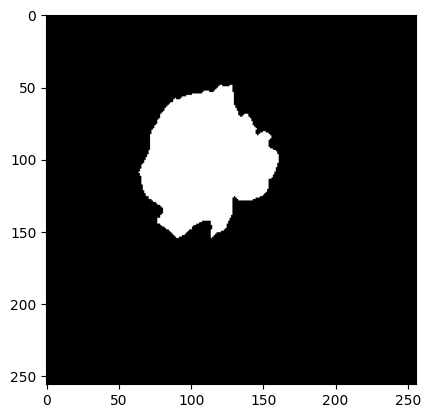

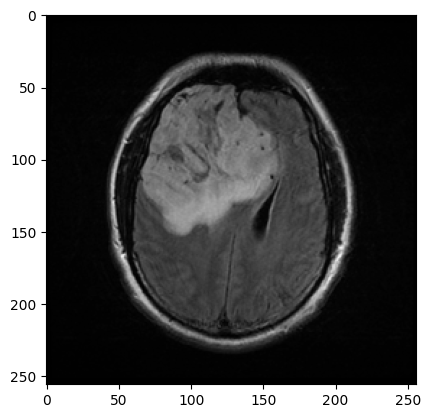

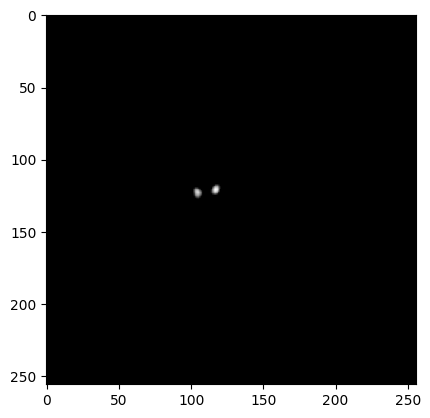

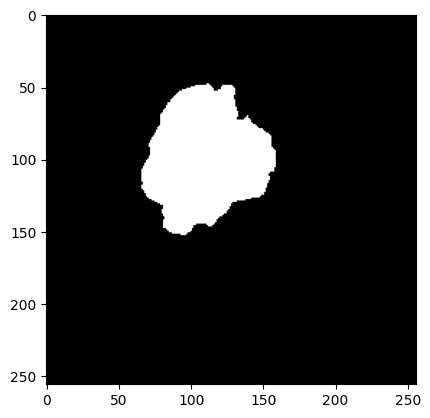

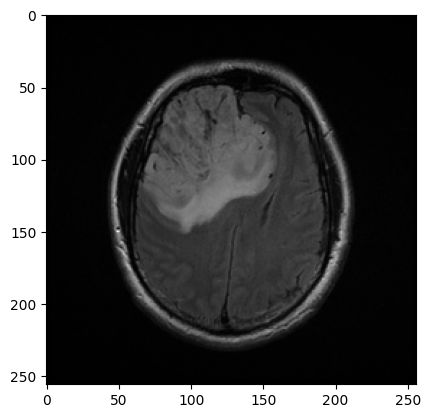

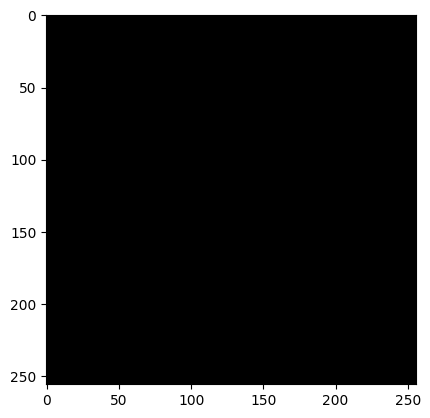

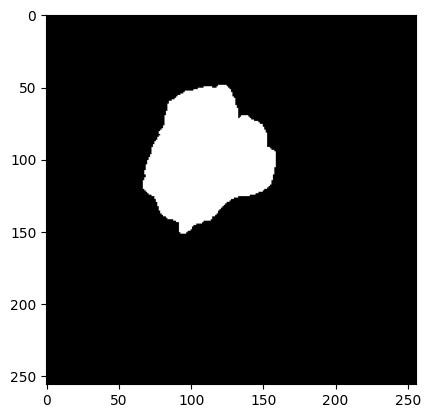

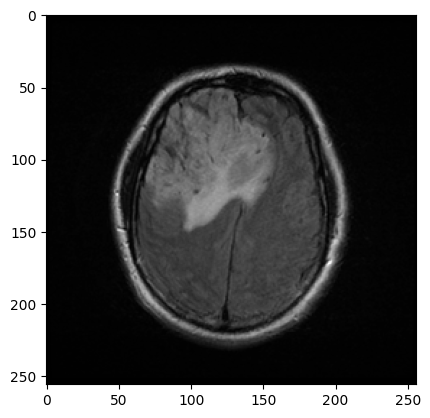

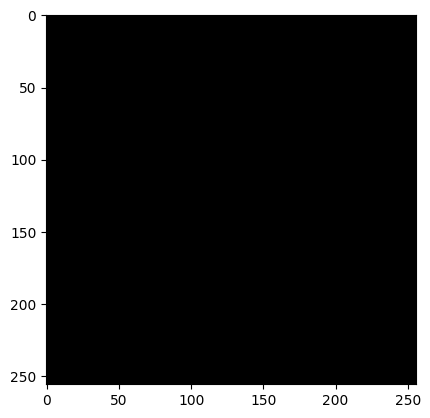

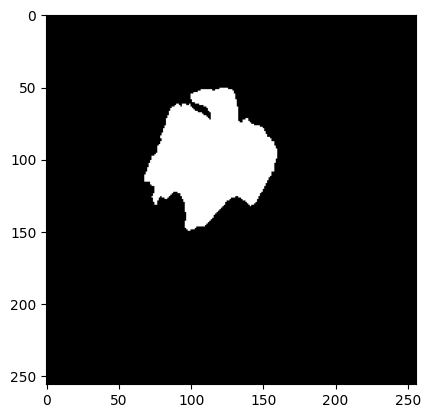

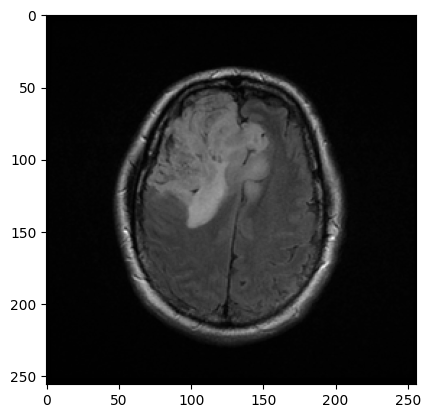

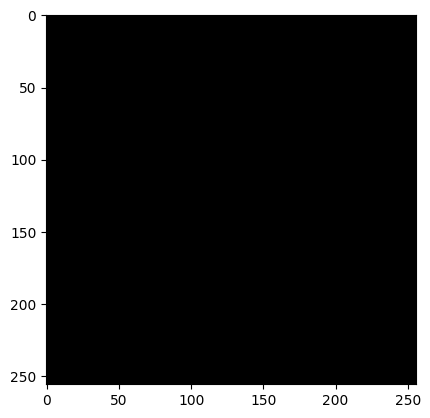

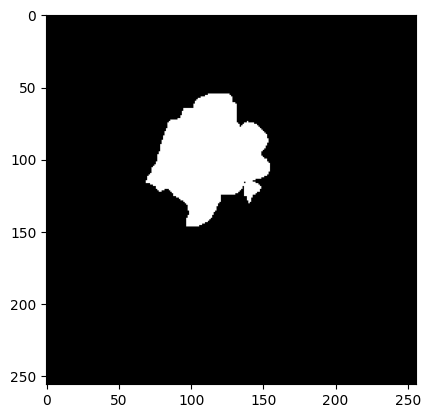

In [ ]:
ev = []
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        # evaluate performance on test set
        iou_scores = []
        for i in range(outputs.shape[0]):
            plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
            # Save the image to a file
            plt.imsave('image{}{}.png'.format(images[i].shape[0],i), np.squeeze(images[i].cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()), cmap='gray')
            plt.imsave('outputs{}{}.png'.format(outputs[i].shape[0],i), np.squeeze(F.threshold(outputs[i],threshold, 0).cpu().numpy()))
            plt.show()
            plt.imshow(np.squeeze(masks[i].cpu().numpy()), cmap='gray')
            plt.imsave('masks{}{}.png'.format(masks[i].shape[0],i), np.squeeze(masks[i].cpu().numpy()))
            plt.show()
            iou = calculate_iou(F.threshold(outputs[i],threshold, 0), masks[i])
            iou_scores.append(iou)
        ev.extend(iou_scores)

In [ ]:
# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
ev

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
sum(ev) / len(ev)

0.09018162318638392

# End Of Project

In [ ]:
only_original = []
only_mask = []
word = "mask.tif"
for pathx in sorted_file_paths:
    if (word not in pathx) and ("tif" in pathx):
        only_original.append(pathx)
    elif word in pathx:
        only_mask.append(pathx)
    else:
        print(pathx)
#only_original = sorted_file_paths.str.contains("")

C:\newJupyterProject\NMA\lgg-mri-segmentation\kaggle_3m\README.md
C:\newJupyterProject\NMA\lgg-mri-segmentation\kaggle_3m\data.csv


In [ ]:
only_original

['C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif',
 'C:\\newJupyterProject\\NMA\\lgg-mri-segmentation\\kaggle_3m\\TC

In [ ]:
only_original.sorted()

In [ ]:
# Create data_path list contains all image path
original_path = []
mask_path = []
for sub_dir_pat

In [ ]:
# Create data_path list contains all image path
original_path = []
mask_path = []
for sub_dir_path in glob.glob("lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            if filename.str.contains("mask"):
                mask = sub_dir_path + '/' + filename
                mask_path.append(mask)
            else:
                original = sub_dir_path + '/' + filename
                original_path.append(original)
            #data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[WinError 267] The directory name is invalid: 'lgg-mri-segmentation/kaggle_3m\\data.csv'
[WinError 267] The directory name is invalid: 'lgg-mri-segmentation/kaggle_3m\\README.md'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'str' object has no attribute 'contains'
'

In [ ]:
len(data_path)

15716

In [ ]:
filenames = data_path[::2]
masks = data_path[1::2]

In [ ]:
filenames[0]

'kaggle_3m\\TCGA_CS_4941_19960909'

In [ ]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print(df.shape)
df

(7858, 2)


,patient_id,img_path
0,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
1,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
2,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
3,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
4,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
...,...,...
7853,kaggle_3m\TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19...
7854,kaggle_3m\TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19...
7855,kaggle_3m\TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19...
7856,kaggle_3m\TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19...


In [ ]:
# Split the dataframe into 2 dataframe: 1 for image and 1 for mask
original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [ ]:
import re
pattern = r'(\d+)_mask'
def extract_numbers(s):
    match = re.search(pattern,s)
    if match:
        return int(match.group(1))
    else:
        return -1

In [ ]:
sorted_original_img = []

In [ ]:
def sorting_func(my_list,sorted_list):
    for i in range(0,len(my_list),20):
        sorted_list.extend(sorted(my_list[i:i+20],key = extract_numbers()))
    return sorted_list

In [ ]:
sorted_original_img = sorting_func

In [ ]:
len(list(original_img["img_path"]))

3929

In [ ]:
len(list(mask_img["img_path"]))

3929

In [ ]:
df_final = pd.DataFrame(data={"patient_id": original_img.patient_id.values,"oringinal_img_path": list(original_img["img_path"]),"mask_img_path":list(mask_img["img_path"])})

In [ ]:
df_final["oringinal_img_path"].iloc[0],df_final["mask_img_path"].iloc[0]

('lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif')

In [ ]:
for i in range(20):
    print(original_img["img_path"].iloc[i])#,mask_img["img_path"].iloc[0]

lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif
lgg-mri-segmentati

In [ ]:
# Sorting based on numerical order
imgs = sorted(original_img['img_path'].values)
masks = sorted(mask_img["img_path"].values)

In [ ]:
imgs

['lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_49

In [ ]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df.head()

,patient_id,img_path,mask_path
0,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
1,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
2,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
3,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
4,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...


In [ ]:
mri_df["img_path"].iloc[0],mri_df["mask_path"].iloc[0]

('lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif')